# Logistic Regression

## Task 🌯

You'll use a [**dataset of 400+ burrito reviews**](https://srcole.github.io/100burritos/). How accurately can you predict whether a burrito is rated 'Great'?

> We have developed a 10-dimensional system for rating the burritos in San Diego. ... Generate models for what makes a burrito great and investigate correlations in its dimensions.

- Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
- Begin with baselines for classification.
- Use scikit-learn for logistic regression.
- Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
- Get your model's test accuracy. (One time, at the end.)


## Stretch Goals

- Add your own stretch goal(s) !
- Make exploratory visualizations.
- Do one-hot encoding.
- Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- Get and plot your coefficients.
- Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [1]:
# Create your data path
from pathlib import Path
import os
DATA_PATH = Path.cwd().parent.joinpath('data')
print(DATA_PATH)
print(os.listdir(DATA_PATH))

/home/studio-lab-user/intuit-ga-dat15/lectures/09-logistic-regression-classifier/data
['admissions.csv', 'bank.csv', 'bankruptcy.csv', 'burritos_cleaned.csv', 'evergreen_sites.tsv', 'glass.csv', 'glass.names', 'loan_data_set.csv', 'titanic']


In [2]:
# specify the burritos.csv file
filename = Path.joinpath(DATA_PATH, 'burritos_cleaned.csv')
filename

PosixPath('/home/studio-lab-user/intuit-ga-dat15/lectures/09-logistic-regression-classifier/data/burritos_cleaned.csv')

In [3]:
# read in the dataframe
import numpy as np
import pandas as pd
df = pd.read_csv(filename)
df.shape

(421, 56)

In [4]:
# take a look
df.sample(3)

,Burrito,Date,Chips,Cost,Hunger,Length,Circum,Volume,Tortilla,Temp,...,Nopales,Lobster,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
228,Carnitas,9/13/2016,0,7.15,4.0,16.5,26.5,0.92,2.5,2.5,...,0,0,0,0,0,0,0,1,0,False
298,Other,12/15/2016,0,6.99,3.7,24.0,18.5,0.65,3.6,4.0,...,0,0,0,0,0,0,0,0,0,False
305,Surf & Turf,1/12/2017,0,7.89,3.0,18.5,25.5,0.96,4.0,5.0,...,0,0,0,0,0,0,0,0,0,True


Contrary to popular belief, burritos do not merely exist in 3 dimensions. They transcend the physical limitations of space. From polling several San Diegans, we’ve established the 10 core dimensions of the San Diego burrito. 
All of these measures (except for Volume) are rated on a scale from 0 to 5, 0 being terrible, and 5 being optimal.

- Volume - “size matters,” “bigger is better,” or whatever your favorite innuendo is fits because there’s nothing more disconcerting than ordering a burrito and not being full.
- Tortilla quality
- Temperature - the Goldilocks zone
- Meat quality
- Non-meat filling quality
- Meat : filling - The ratio between meat and non-meat. Perhaps the golden ratio: 1.6180339887…
- Uniformity - Bites full of sour cream and cheese with no meat are disappointing.
- Salsa quality - and variety!
- Flavor synergy - "That magical aspect a great burrito has, making everything come together like it is a gift from the skies" - A wise Dutchman
- Wrap integrity - you ordered a burrito, not a burrito bowl.  

Cost (in USD) and hunger level (on the same 0-5 scale) are measured as potential control factors. In addition to these 10 core dimensions, we also collect two summary statistics:

- Overall rating - 0 to 5 stars
- Recommendation - Yes/No. If a friend asked you about that burrito with the intent of purchasing one, would you recommend it?

In [5]:
ratings=['overall','Rec','Synergy','Tortilla', 'Meat', 'Salsa', 'Wrap','Fillings','Meat:filling', 'Unreliable']

## Data Preparation

In [6]:
# what are the columns?
df.columns

Index(['Burrito', 'Date', 'Chips', 'Cost', 'Hunger', 'Length', 'Circum',
       'Volume', 'Tortilla', 'Temp', 'Meat', 'Fillings', 'Meat:filling',
       'Uniformity', 'Salsa', 'Synergy', 'Wrap', 'overall', 'Rec',
       'Unreliable', 'NonSD', 'Beef', 'Pico', 'Guac', 'Cheese', 'Fries',
       'Sour cream', 'Pork', 'Chicken', 'Shrimp', 'Fish', 'Rice', 'Beans',
       'Lettuce', 'Tomato', 'Bell peper', 'Carrots', 'Cabbage', 'Sauce',
       'Salsa.1', 'Cilantro', 'Onion', 'Taquito', 'Pineapple', 'Ham',
       'Chile relleno', 'Nopales', 'Lobster', 'Egg', 'Mushroom', 'Bacon',
       'Sushi', 'Avocado', 'Corn', 'Zucchini', 'Great'],
      dtype='object')

In [7]:
# Check for missing data
df.isnull().sum().sort_values(ascending=False).head()

Volume       144
Circum       140
Length       138
Burrito        0
Pineapple      0
dtype: int64

In [8]:
# impute the missing data using the average of the column
for col in ['Volume', 'Circum', 'Length' ]:
    df[col]=df[col].fillna(round(df[col].mean(), 2))

In [9]:
# Confirm that fixed the problem
for col in ['Volume', 'Circum', 'Length' ]:
    print(col, df[col].isnull().sum())

Volume 0
Circum 0
Length 0


In [10]:
# Drop some columns -- these are related to our target var - to prevent "leakage"
# we also drop the date column because it's not immediately useable
df = df.drop(columns=['Rec', 'overall', 'Date'], axis=1)
df.head()

,Burrito,Chips,Cost,Hunger,Length,Circum,Volume,Tortilla,Temp,Meat,...,Nopales,Lobster,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,California,0,6.49,3.0,20.04,22.14,0.79,3.0,5.0,3.0,...,0,0,0,0,0,0,0,0,0,False
1,California,0,5.45,3.5,20.04,22.14,0.79,2.0,3.5,2.5,...,0,0,0,0,0,0,0,0,0,False
2,Carnitas,0,4.85,1.5,20.04,22.14,0.79,3.0,2.0,2.5,...,0,0,0,0,0,0,0,0,0,False
3,Asada,0,5.25,2.0,20.04,22.14,0.79,3.0,2.0,3.5,...,0,0,0,0,0,0,0,0,0,False
4,California,1,6.59,4.0,20.04,22.14,0.79,4.0,5.0,4.0,...,0,0,0,0,0,0,0,0,0,True


In [11]:
# check out the categorical variable
df['Burrito'].value_counts()

California     169
Other          156
Asada           43
Surf & Turf     28
Carnitas        25
Name: Burrito, dtype: int64

In [12]:
# convert the categorical variable to dummies via one-hot encoding
onehot = pd.get_dummies(df['Burrito'])
onehot.head()

,Asada,California,Carnitas,Other,Surf & Turf
0,0,1,0,0,0
1,0,1,0,0,0
2,0,0,1,0,0
3,1,0,0,0,0
4,0,1,0,0,0


In [13]:
# use pd.concat to join the new columns with your original dataframe
df = pd.concat([df,onehot],axis=1)
df[['Burrito', 'Asada','California','Carnitas','Other','Surf & Turf']].head()

,Burrito,Asada,California,Carnitas,Other,Surf & Turf
0,California,0,1,0,0,0
1,California,0,1,0,0,0
2,Carnitas,0,0,1,0,0
3,Asada,1,0,0,0,0
4,California,0,1,0,0,0


In [14]:
# now drop the original column (you don't need it anymore)
df=df.drop(['Burrito'],axis=1)
df.shape

(421, 57)

## Classification Task

In [15]:
# Establish the target variable: is it a great burrito?
y = df['Great']
print(y.shape)

(421,)


In [16]:
# Establish the matrix of features: what predicts that it's great?
X = df.drop('Great', axis=1)
print(X.shape)

(421, 56)


In [17]:
# split your data into training and testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [18]:
# import the logistic regression classifier
from sklearn.linear_model import LogisticRegression

In [19]:
# instantiate the model (note we increase max-iter here; default is 100)
logreg = LogisticRegression(max_iter=1000)

In [20]:
# fit your model on the training dataset
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

## Examine the coefficients

In [21]:
# what is the intercept?
logreg.intercept_

array([-29.46455821])

In [22]:
# what are the coefficients?
logreg.coef_

array([[ 0.30344908,  0.35753942,  0.14724934,  0.17065475, -0.10718582,
        -0.05331285,  0.57380122,  0.6186651 ,  1.48118236,  1.1403796 ,
         1.03747394,  0.09426329,  0.32994341,  1.64437087,  0.04263559,
         0.53015912,  0.13488654, -0.44505984, -0.68642331,  0.3909573 ,
         0.07049938, -0.09063006,  0.12406374,  0.4035336 ,  0.02767695,
        -0.18678008, -0.24277351, -0.15710969, -1.01943668, -0.13654015,
        -0.21924924, -0.05842856,  0.        , -0.25164165, -0.29573614,
        -0.305755  , -0.0314081 , -0.11352546,  0.15424687, -0.63977826,
         0.3454612 ,  0.18859061,  0.42841835, -0.05590088,  0.07448448,
         0.02688156,  0.14990478,  0.16409501,  0.0373818 , -0.24010793,
         0.03685113,  0.53580685,  0.03090331,  0.28355204, -0.57667711,
        -0.2762066 ]])

In [23]:
# display the coefficients as a dataframe
feature_cols = X.columns
coeffs=pd.DataFrame(list(zip(feature_cols, logreg.coef_[0])), columns=['feature','coef'])
coeffs.set_index('feature', inplace=True)
coeffs.sort_values('coef', ascending=False).head(15)

,coef
feature,
Synergy,1.644371
Meat,1.481182
Fillings,1.140380
Meat:filling,1.037474
Temp,0.618665
Tortilla,0.573801
Asada,0.535807
Unreliable,0.530159
Nopales,0.428418


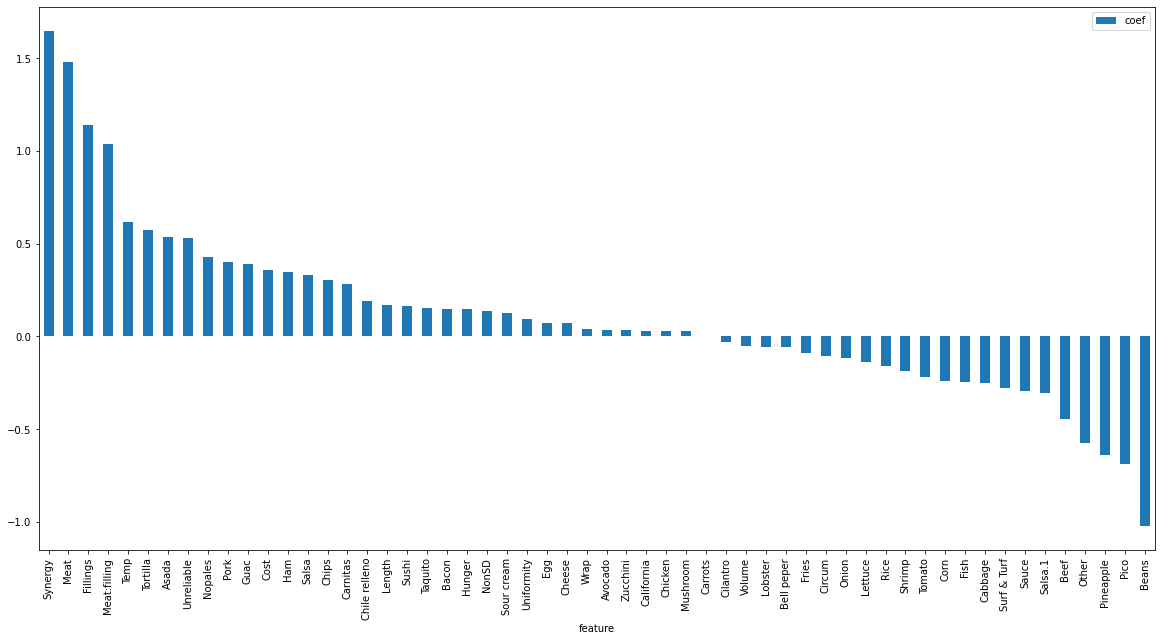

In [24]:
# display the coefficients as a bar chart
coeffs.sort_values('coef', ascending=False).plot(kind='bar', figsize=(20,10));

These coefficients are "log odds", which is a kind of probability, as follows.
* log odds = 0 indicates even probability
* log odds < 0 indicates less likely to occur
* log odds > 0 indicates more likely to occur

<img src="../assets/conversions.png"
     alt="conversions"
     style="float: left; margin-right: 10px;" />

## Make predictions & evaluate the model

In [25]:
# predict on the testing dataset
y_preds=logreg.predict(X_test)
print('preds', list(y_preds[:10]))
print('truth', list(y_test[:10]))

preds [True, True, False, False, True, False, True, False, False, False]
truth [True, True, True, False, True, False, False, False, False, False]


In [26]:
# does it match y-test?
print(len(y_preds))
print(len(y_test))

106
106


In [27]:
# calculate the accuracy of your predictions
from sklearn.metrics import accuracy_score
print(accuracy_score(y_preds, y_test))

0.8490566037735849


In [28]:
# compare that to a baseline score!
# what is the majority class of the target?
print(y_train.value_counts())

False    170
True     145
Name: Great, dtype: int64


In [29]:
# just guess that it's always the majority class.
# how does that effect accuracy?
baseline_preds = np.empty(len(y_test))
baseline_preds.fill(False)
print(accuracy_score(baseline_preds, y_test))

0.6509433962264151


In [30]:
# improvement over baseline
print(accuracy_score(y_preds, y_test) - accuracy_score(baseline_preds, y_test))

0.19811320754716988


In [ ]:
# try adding and removing features and see how that changes the accuracy score!